# Bonus session 5: Implementing a simple Eco-Evolutionary simulation

In all precedent sessions, we saw how to control simulation from notebook by modifying agents behaviors, manipulating their sensors, their diets ... how to make ressources spawn, assign species to agents ......, attach routines ...

Now we are going to see how we can combine all these features to implement a simple Eco-Evolutionary simulation ! 

ChatGPT : An eco-evolutionary simulation is a virtual environment where small agents (like robots) interact with each other and their surroundings. Over time, these agents adapt and evolve based on environmental challenges and competition for resources. The simulation models both ecological processes (like food gathering or predator-prey relationships) and evolutionary changes (like traits being passed down to future generations).

In [1]:
# for this notebook
robots_id = 0
ressources = 1 
s_obstacles = 2
b_obstacles = 3

In [2]:
def fear(robot):
    left, right = robot.sensors(sensed_entities=[robots_id])
    left_wheel = left
    right_wheel = right
    return left_wheel, right_wheel

def aggression(robot):
    left, right = robot.sensors(sensed_entities=[robots_id])
    left_wheel = right
    right_wheel = left
    return left_wheel, right_wheel

def love_cuddly(robot):
    left, right = robot.sensors(sensed_entities=[robots_id])
    left_wheel = 1 - left
    right_wheel = 1 - right   
    return left_wheel, right_wheel

def love_shy(robot):
    left, right = robot.sensors(sensed_entities=[robots_id])
    left_wheel = 1 - right
    right_wheel = 1 - left   
    return left_wheel, right_wheel

def obstacle_avoidance(robot):
    left, right = robot.sensors(sensed_entities=[s_obstacles, b_obstacles])
    left_wheel = 1 - right
    right_wheel = 1 - left   
    return left_wheel, right_wheel

In [3]:
import time
import numpy as np

from vivarium.controllers.notebook_controller import NotebookController
from vivarium.utils.handle_server_interface import start_server_and_interface, stop_server_and_interface

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [4]:
start_server_and_interface(scene_name="session_5")

STARTING SERVER


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[2024-10-22 17:36:44,333][__main__][INFO] - Scene running: session_5
[2024-10-22 17:36:46,959][vivarium.simulator.simulator][INFO] - Simulator initialized
[2024-10-22 17:36:46,959][__main__][INFO] - Simulator server started

STARTING INTERFACE


2024-10-22 17:36:49,734 Starting Bokeh server version 3.3.4 (running on Tornado 6.4)
2024-10-22 17:36:49,735 User authentication hooks NOT provided (default user enabled)
2024-10-22 17:36:49,736 Bokeh app running at: http://localhost:5006/run_interface
2024-10-22 17:36:49,736 Starting Bokeh server with process id: 39893
2024-10-22 17:36:53,272 An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [5]:
controller = NotebookController()

/home/cleger/Desktop/code/vivarium/venv/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


In [6]:
controller.run()

2024-10-22 17:36:54,984 WebSocket connection opened
2024-10-22 17:36:55,034 ServerConnection created


[134.03761292 169.49101257 118.28668976]
False
[134.03761292  88.45828247 185.52972412]
False
[169.49101257  88.45828247 167.01502991]
False
[118.28670502 185.52972412 167.01501465]
False
[134.03761292 169.49101257 118.28668976]
False
[134.03761292  88.45828247 185.52972412]
False
[169.49101257  88.45828247 167.01502991]
False
[118.28670502 185.52972412 167.01501465]
False
[134.03761292 169.49101257 118.28668976]
False
[134.03761292  88.45828247 185.52972412]
False
[169.49101257  88.45828247 167.01502991]
False
[118.28670502 185.52972412 167.01501465]
False
[134.03761292 169.49101257 118.28668976]
False
[134.03761292  88.45828247 185.52972412]
False
[169.49101257  88.45828247 167.01502991]
False
[118.28670502 185.52972412 167.01501465]
False
[134.03761292 169.49101257 118.28668976]
False
[134.03761292  88.45828247 185.52972412]
False
[169.49101257  88.45828247 167.01502991]
False
[118.28670502 185.52972412 167.01501465]
False
[134.03761292 169.49101257 118.28668976]
False
[134.03761292

## Understanding alive and dead agents

In [7]:
n_agents = len(controller.agents)
print(f"Number of agents: {n_agents}")

Number of agents: 10


We can see there are only 4 agents in the simulator. 10 is the max number of agents. We can check this with the following command and see which agents are dead or alive :

In [8]:
for agent in controller.agents:
    print(agent.exists)

True
True
True
True
False
False
False
False
False
False


First 4 agents of the simulator are alive ... Now we are going to see how to make an agent spawn and die:

In [9]:
agent_idx = 4 # idx of a dead agent
agent = controller.agents[agent_idx]
agent.exists = True # make the agent spawn

we can also do it with the spawn_entity function of the controller :

In [10]:
agent_idx = 5 # idx of a dead agent
controller.spawn_entity(agent_idx)

Now let's see how to make an agent die :

In [11]:
agent_idx = 3 # idx of an alive agent
agent = controller.agents[agent_idx]
agent.exists = False # kill the agent

And again we have a method in the controller to do that : remove_entity

In [12]:
agent_idx = 5 # idx of an alive agent
controller.remove_entity(agent_idx)

Now you can make agents spwan and die ! 

Attach behaviors to existing agents (you can technically also attach them to dead agents but it won't have any effect):

In [13]:
for agent in controller.agents:
    if agent.exists == True:
        agent.attach_behavior(obstacle_avoidance)
        agent.attach_behavior(love_cuddly)
        agent.start_all_behaviors()

In [14]:
for agent in controller.agents:
    agent.check_behaviors()

Available behaviors: ['obstacle_avoidance', 'love_cuddly'], Active behaviors: ['obstacle_avoidance', 'love_cuddly']
Available behaviors: ['obstacle_avoidance', 'love_cuddly'], Active behaviors: ['obstacle_avoidance', 'love_cuddly']
Available behaviors: ['obstacle_avoidance', 'love_cuddly'], Active behaviors: ['obstacle_avoidance', 'love_cuddly']
No behaviors attached
Available behaviors: ['obstacle_avoidance', 'love_cuddly'], Active behaviors: ['obstacle_avoidance', 'love_cuddly']
No behaviors attached
No behaviors attached
No behaviors attached
No behaviors attached
No behaviors attached


## Comment : Funny emergent behavior

Could add this in a session, agents start behavior like a kind of spine and follow each other while detecting themselves at max range --> very like life phenomenon liek a kind of snake

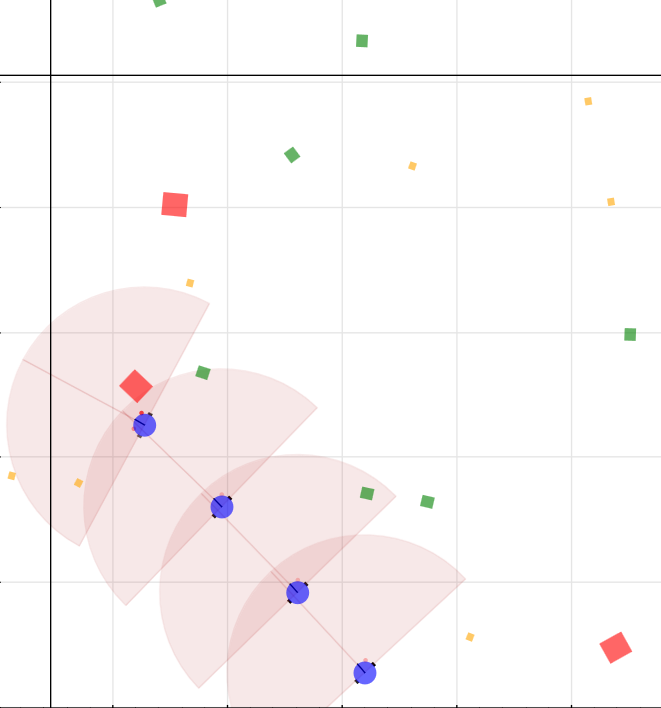

And actually seems to last forever with the current configutation ! even with obstacles on the side


Start object apparition and make agents eat them

In [15]:
def foraging(robot):
    left, right = robot.sensors(sensed_entities=[ressources])
    left_activation = right
    right_activation = left
    return left_activation, right_activation

In [16]:
controller.start_ressources_apparition(period=10)

In [17]:
for agent in controller.agents:
    agent.diet = [ressources]
    agent.detach_behavior("love_cuddly")
    agent.attach_behavior(foraging)
    agent.start_all_behaviors()

## Add asexual reproduction with a simple agent routine

if agents have a certain energy level / have eaten, they can produce an offspring. We can implement this with a simple agent routine.

First, use a little trick to get the indexes of the agents that are not alive so we can pick one to spawn the offspring :

In [18]:
dead_agents_idx = [agent.idx for agent in controller.agents if agent.exists == False]
print(dead_agents_idx)

[3, 5, 6, 7, 8, 9]


then, to pick a random idx inside the list of dead agents, use the numpy random choice function : (note that if you execute the function several times, you will see that the idx is different each time)

In [19]:
agent_idx = np.random.choice(dead_agents_idx)
print(agent_idx)

6


In [20]:
offspring_diamter = 7.

def spawn_offspring_v0(robot): 
    if robot.has_eaten():
        dead_agents_idx = [agent.idx for agent in controller.agents if agent.exists == False]
        # check if there are remaining dead agents
        if dead_agents_idx:
            # if possible, spawn an agent and attach behaviors
            agent_idx = np.random.choice(dead_agents_idx)
            offspring = controller.spawn_entity(agent_idx, position=None) # None means no position defined --> random position that was already assigned to the agent
            offspring.diameter = offspring_diamter # make the agent smaller when it spawns
            # we could imagine attaching speciifc behaviors to the offspring / give them specific weights !
            offspring.attach_behavior(obstacle_avoidance)
            offspring.attach_behavior(foraging)
            offspring.start_all_behaviors()
        else:
            # do nothing
            pass

In [21]:
for agent in controller.agents:
    agent.ate = False
    agent.attach_routine(spawn_offspring_v0)

In [22]:
for agent in controller.agents:
    agent.check_behaviors()

Available behaviors: ['obstacle_avoidance', 'foraging'], Active behaviors: ['obstacle_avoidance', 'foraging']
Available behaviors: ['obstacle_avoidance', 'foraging'], Active behaviors: ['obstacle_avoidance', 'foraging']
Available behaviors: ['obstacle_avoidance', 'foraging'], Active behaviors: ['obstacle_avoidance', 'foraging']
Available behaviors: ['foraging'], Active behaviors: ['foraging']
Available behaviors: ['obstacle_avoidance', 'foraging'], Active behaviors: ['obstacle_avoidance', 'foraging']
Available behaviors: ['foraging'], Active behaviors: ['foraging']
Available behaviors: ['foraging'], Active behaviors: ['foraging']
Available behaviors: ['foraging'], Active behaviors: ['foraging']
Available behaviors: ['foraging'], Active behaviors: ['foraging']
Available behaviors: ['foraging'], Active behaviors: ['foraging']


Kill half the agents and improve the above function to make offsprings spawn next to their parent

To prevent errors in collisions, add a little epsilon to the modify the position of the offspring with numpy:

In [23]:
agent_idx = 0
# get agent position
position = [agent.x_position, agent.y_position]
print(f"position = {position}")

# epsilon between -max_distance and +max_distance, of shape (2)
max_distance = 5
epsilon = np.random.uniform(-max_distance, max_distance, 2)
print(f"epsilon = {epsilon}")

# create new position by adding epsilon to the current position
new_position = position + epsilon
print(f"new_position = {new_position}")

position = [17.2849063873291, 6.892883777618408]
epsilon = [4.35443504 1.39501772]
new_position = [21.63934143  8.2879015 ]


In [24]:
def spawn_offspring_v1(robot): 
    if robot.has_eaten():
        dead_agents_idx = [agent.idx for agent in controller.agents if agent.exists == False]
        if dead_agents_idx:
            agent_idx = np.random.choice(dead_agents_idx)
            # add some noise to the position
            epsilon = np.random.uniform(-max_distance, max_distance, 2)
            position = [robot.x_position, robot.y_position]
            new_position = position + epsilon
            # give the new position to the spawn entity
            offspring = controller.spawn_entity(agent_idx, position=new_position) 
            offspring.diameter = 7.
            offspring.attach_behavior(obstacle_avoidance)
            offspring.attach_behavior(foraging)
            offspring.start_all_behaviors()
        else:
            pass

In [25]:
for idx in range(5, n_agents):
    controller.remove_entity(idx)

Entity 5 already removed
Entity 6 already removed
Entity 7 already removed
Entity 8 already removed
Entity 9 already removed


In [26]:
for agent in controller.agents:
    agent.detach_all_routines()
    agent.ate = False
    agent.attach_routine(spawn_offspring_v1)

## Add sexual reproduction with a controller routine

Nice, now we have agents that can spawn offsprings next to them when they eat ! We could also think of other types of reproduction, for example if two agents are close to each other, they can reproduce. We can implement this with a simple controller routine.

First, stop all the agents and remove their current behaviors and routines.

In [27]:
for agent in controller.agents:
    agent.detach_all_routines()
    agent.detach_all_behaviors(stop_motors=True)

Entity 5 already removed
Entity 7 already removed


In [65]:
for idx in range(5, n_agents):
    controller.remove_entity(idx)

Entity 6 already removed
Entity 7 already removed
Entity 9 already removed


In [43]:
for agent in controller.agents:
    agent.can_reproduce = True

In [60]:
reproduction_range = 30.

def agents_reproduction(controller):
    """make agents of the simulation eating the entities in their diet

    :param controller: NotebookController
    """
    for agent in controller.agents:
        # skip to next agent if the agent does not exist
        if not agent.exists:
            continue
        # get the index of the other existing agents
        other_existing_agents_idx = [ent.idx for ent in controller.agents if ent.exists == True and ent.idx != agent.idx]
        distances = agent.config.proximity_map_dist[other_existing_agents_idx]
        in_range = distances < reproduction_range
        found_mate = np.any(in_range)
        # need to eat a ressource and find a mate to reproduce
        if found_mate and agent.can_reproduce:
            # copy the code of the spawn_offspring_v1 routine
            # TODO : see if we copy all this or if we can encapsulate it in a function (but idk if students will be comfortable with functions)
            dead_agents_idx = [agent.idx for agent in controller.agents if agent.exists == False]
            if dead_agents_idx:
                agent_idx = np.random.choice(dead_agents_idx)
                # add some noise to the position
                epsilon = np.random.uniform(-max_distance, max_distance, 2)
                position = [agent.x_position, agent.y_position]
                new_position = position + epsilon
                # give the new position to the spawn entity
                offspring = controller.spawn_entity(agent_idx, position=new_position) 
                offspring.diameter = offspring_diamter
                offspring.attach_behavior(obstacle_avoidance)
                offspring.attach_behavior(foraging)
                offspring.start_all_behaviors()
                # pretty funny to remove this line, does a kind of explosion of spawning agents
                offspring.can_reproduce = False
                agent.can_reproduce = False
            else:
                pass

In [59]:
controller.stop()

In [61]:
controller.attach_routine(agents_reproduction)

In [62]:
controller.run()

In [63]:
for agent in controller.agents:
    agent.ate = False
    agent.detach_all_behaviors(stop_motors=True)
    agent.attach_behavior(obstacle_avoidance)
    agent.attach_behavior(love_shy)
    agent.attach_behavior(foraging)
    agent.start_all_behaviors()

## Make agents eat each other

We can make agents eat each other by simply using the diet attribute of the agent ! Let's create prey and predator agents and add preys in the diet of predators.

In [10]:
for agent in controller.agents:
    agent.diet = [ressources]

Note that the cell above is a shortcut to execute the same set of instructions (the indented lines) on all the robots returned by the `open_session` function (the one you use to connect to the simulator). It can become very useful when you want to run the same set of instructions on all the robots, as it is the case here. 

**Q1:** You will observe that the robots seem to be attracted to objects that are not handled by the behavior (e.g. other robots). Analyse this phenomena and explain below why it is occuring in a few lines:

*Double click on this cell to enter your answer*

In [66]:
stop_server_and_interface()
controller.stop()

Received signal 15, shutting down
Server and Interface Stopped
